# LSTM + CNN approach

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras                                                
from datetime import datetime
import IPython.display as ipd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def features_extract(file):
    audio, sam = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sam, n_mfcc=40)
    mfcc_scaled = np.mean(mfccs_features.T, axis=0)
    return mfcc_scaled

# Path to the directory containing audio files
path = "C:\\Users\\abhih\\OneDrive\\Desktop\\tdl_project\\TESS Toronto emotional speech set data"

extracted_features = []
all_files = os.listdir(path)
for sets in tqdm(all_files, desc="Processing Directories"):
    cur_path = os.path.join(path, sets)
    for file_name in tqdm(os.listdir(cur_path), desc="Processing Files in {}".format(sets), leave=False):
        data = features_extract(os.path.join(cur_path, file_name))
        extracted_features.append([sets, data])

Processing Directories: 100%|██████████| 14/14 [01:35<00:00,  6.86s/it]


In [4]:
voice = pd.DataFrame(extracted_features, columns=['Mood', 'Data'])

# Preprocess data
X = np.array(voice['Data'].tolist())
y = np.array(voice['Mood'].apply(lambda x: x.lower().split('_')[1]))

In [5]:
label = LabelEncoder()
y = to_categorical(label.fit_transform(y))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model


In [9]:
acc_per_fold = []

y_labels = np.argmax(y, axis=1)

for index, (train_index, test_index) in enumerate(skf.split(X, y_labels)):
    print(f"Training on Fold {index + 1}...")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define callbacks
    filepath = f"C:\\Users\\abhih\\OneDrive\\Desktop\\Audio_Emotion_Recognizer\\models\\Audio_Neuron_fold{index + 1}.keras"
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    # Train model
    history = model.fit(X_train, y_train, batch_size=32, epochs=100,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpointer, early_stopping])
    
    # Evaluate model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {index + 1} - Accuracy: {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)

print(f"Average Accuracy: {np.mean(acc_per_fold)}%")


Training on Fold 1...
Epoch 1/100


c:\Users\abhih\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5312 - loss: 1.3520
Epoch 1: val_loss improved from inf to 0.19171, saving model to C:\Users\abhih\OneDrive\Desktop\Audio_Emotion_Recognizer\models\Audio_Neuron_fold1.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5441 - loss: 1.3210 - val_accuracy: 0.9554 - val_loss: 0.1917
Epoch 2/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9676 - loss: 0.1252
Epoch 2: val_loss improved from 0.19171 to 0.10373, saving model to C:\Users\abhih\OneDrive\Desktop\Audio_Emotion_Recognizer\models\Audio_Neuron_fold1.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9675 - loss: 0.1249 - val_accuracy: 0.9732 - val_loss: 0.1037
Epoch 3/100
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9739 - loss: 0.0747
Epoch 3: val_loss improved from 0.10373 to 0.05886, saving model to C:\Users\abhih\OneDrive\Desktop\Audio_Emotion_Recognizer\models\Audio_Neuron_fold1.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.97

In [10]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 17, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,947 (929.48 KB)

 Trainable params: 79,315 (309.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 158,632 (619.66 KB)

In [11]:
print(f"Average Accuracy: {np.mean(acc_per_fold)}%")

Average Accuracy: 99.39285516738892%


In [13]:
keras.saving.save_model(model, 'C:\\Users\\abhih\\OneDrive\\Desktop\\Audio_Emotion_Recognizer\\models\\model_main_cnn_lstm.keras')
print("Model saved successfully.")

Model saved successfully.


In [14]:
data = "C:\\Users\\abhih\\OneDrive\\Desktop\\tdl_project\\voices_testing\\anger.wav" 
ipd.Audio(data) 

In [15]:

final = []
audio, sam = librosa.load(data, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sam, n_mfcc=40)
mfcc_scaled = np.mean(mfccs_features.T, axis=0)
# print(mfcc_scaled)
# Reshape mfcc_scaled to match the input shape of the model
mfcc_scaled = mfcc_scaled.reshape(1, mfcc_scaled.shape[0], 1)

# Print the shape of mfcc_scaled before prediction
print("Shape of mfcc_scaled before prediction:", mfcc_scaled.shape)

predicted = model.predict(mfcc_scaled)

final = []
for i in predicted:
    final.append(np.round(i))

d = label.classes_
print(d)


Shape of mfcc_scaled before prediction: (1, 40, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
['angry' 'disgust' 'fear' 'happy' 'neutral' 'pleasant' 'sad']


In [16]:
print(final)

[array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]


In [17]:
output = []
for i in predicted:
    kp = list(i)
    for i in kp:
        output.append(i)

In [17]:
for i in output:
    print(round(i))  

1
0
0
0
0
0
0


In [18]:
j = 0 
for i in range(len(output)):
    if round(output[i]) == 1:
        print(d[i])
        break

angry


In [19]:
# import pickle
# with open('Emotions.pkl', 'wb') as sounds:
#     pickle.dump(model, sounds) 

In [20]:
# import pickle
# with open('EmotionLabels.pkl', 'wb') as plane:
#     pickle.dump(label, plane) 

In [27]:
# model.save("Neuron/") 

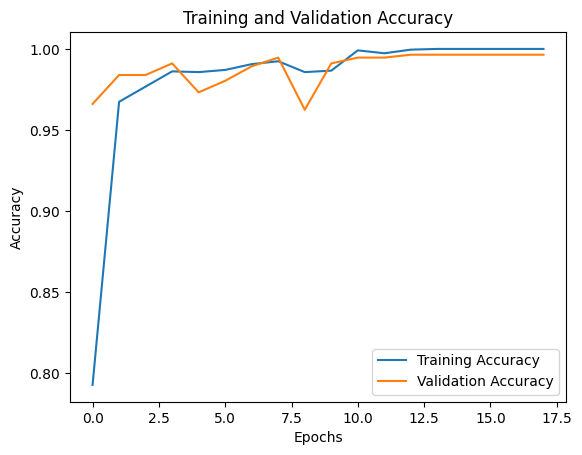

In [19]:
import matplotlib.pyplot as plt

# Training and Validation Accuracy Over Epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

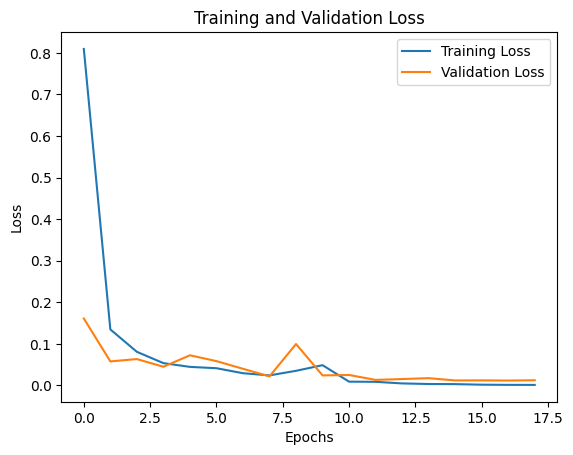

In [20]:
# Training and Validation Loss Over Epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


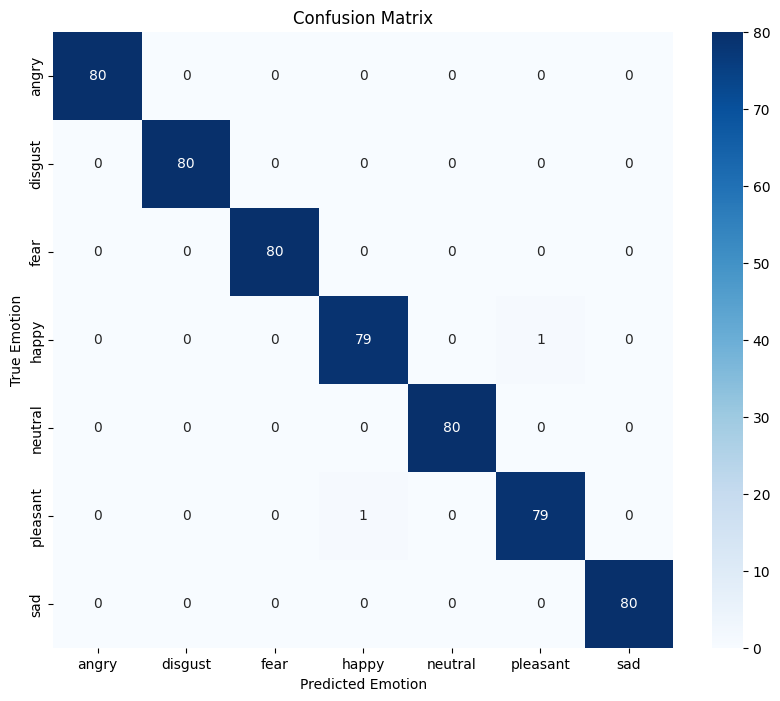

In [21]:

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label.classes_, yticklabels=label.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.show()



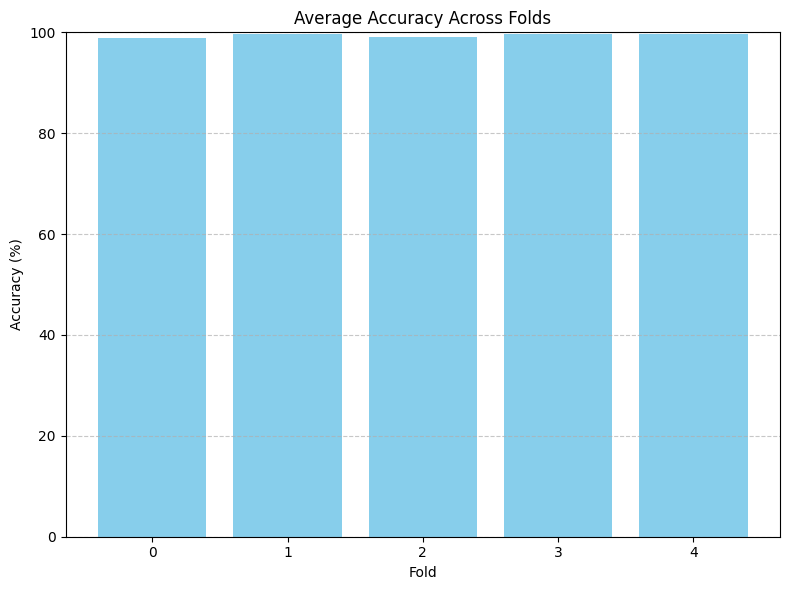

In [22]:
# Bar Plot of Average Accuracy with adjusted size and layout
plt.figure(figsize=(8, 6))
plt.bar(range(len(acc_per_fold)), acc_per_fold, color='skyblue')
plt.title('Average Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(range(len(acc_per_fold)))  # Set x-ticks to match the number of folds
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


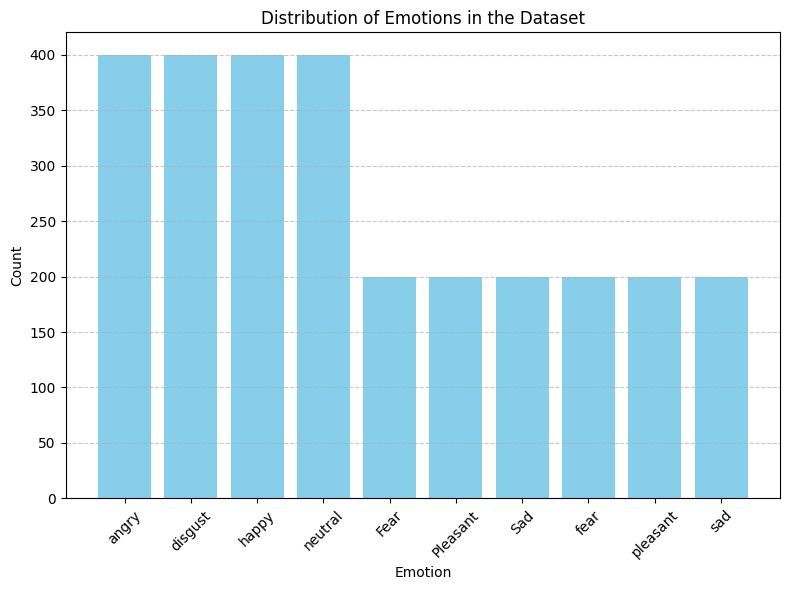

In [23]:
# Distribution of Emotions in the Dataset
emotion_counts = voice['Mood'].apply(lambda x: x.split('_')[1]).value_counts()

plt.figure(figsize=(8, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color='skyblue')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


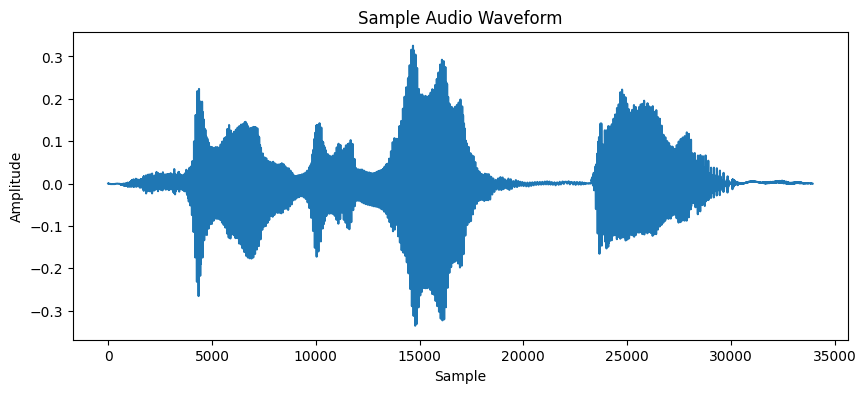

In [24]:

# Sample Audio Waveform
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title('Sample Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


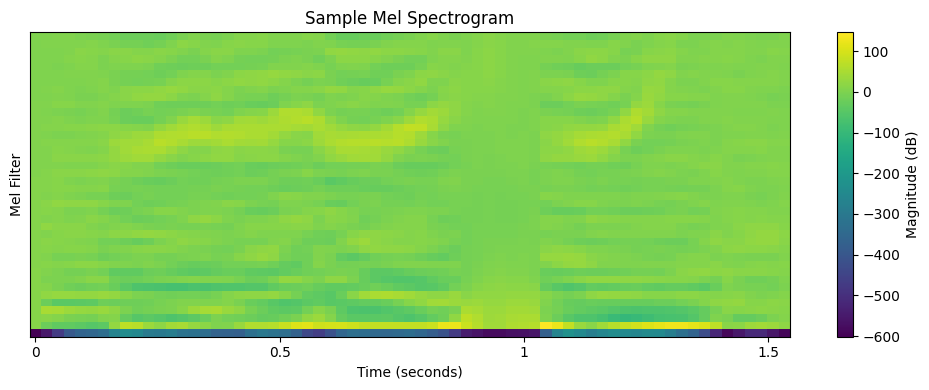

In [25]:
import librosa.display

# Sample Mel Spectrogram with clearer annotations
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_features, sr=sam, x_axis='time', cmap='viridis')
plt.title('Sample Mel Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Mel Filter')
plt.colorbar(label='Magnitude (dB)')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
